# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

# Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/root/.fastai/data/imdb_sample/texts.csv'),
 PosixPath('/root/.fastai/data/imdb_sample/tmp')]

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A TextDataBunch does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [7]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [8]:
data = TextDataBunch.load(path)

# Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

* we need to take care of punctuation
* some words are contractions of two different words, like isn't or don't
* we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [9]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,target
"xxbos xxfld 1 xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxfld 1 xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come",positive
"xxbos xxfld 1 xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n\n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxfld 1 xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj",positive
"xxbos xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj xxunk "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols:

* the "'s" are grouped together in one token
* the contractions are separated like his: "did", "n't"
* content has been cleaned for any HTML symbol and lower cased
* there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

# Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token UNK.

The correspondance from ids tokens is stored in the vocab attribute of our datasets, in a dictionary called itos (for int to string).

In [10]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'xxmaj', 'the', ',', '.', 'and', 'a', 'of', 'to']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [11]:
data.train_ds[0][0]

Text xxbos xxfld 1 i ordered this extremely rare and highly overrated movie on xxunk with very high expectations . i think i paid about 50 $ for this movie . xxmaj as an xxunk fan of horror , from cheesy 80s xxmaj american slashers to xxmaj european zombie films , i told myself this was going to be great ! i ca n't tell you how wrong i was . xxmaj first of all , i thought it was gon na be pretty much xxunk than it actually is . xxmaj after all i 've had heard about this film , i was almost scared to watch it . xxmaj the murders are boring . xxmaj the acting ... forget it , there 's no acting ! xxmaj the story , even if we do n't care , is incredibly bad . xxmaj it seems they tried to get your attention with some weird sexual scenes and naked girls , but unfortunately in this case it does n't help the movie . xxmaj why ? xxmaj there 's no atmosphere , and this is the worst thing about this flick . xxmaj it 's just bad film - making from point a to xxup b. xxmaj though it 's extremely fu

In [12]:
data.train_ds[0][0].data[:10]

array([  44,   45,   40,   13, 3900,   15,  685, 1122,    6,  583])

# With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.



In [13]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

# Language model

Now let's grab the full dataset for what follows.

In [14]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/root/.fastai/data/imdb/test'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/models'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab')]

In [15]:
(path/'train').ls()

[PosixPath('/root/.fastai/data/imdb/train/unsup'),
 PosixPath('/root/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/root/.fastai/data/imdb/train/neg'),
 PosixPath('/root/.fastai/data/imdb/train/pos')]

In [16]:
bs=42

In [17]:
data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

In [18]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [19]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj this is n't a bad xxup tv movie . xxmaj shtrafbat is short for xxmaj xxunk xxmaj xxunk , which means xxmaj penal xxmaj xxunk . xxmaj such xxunk were formed due to the increasing demand for soldiers as the xxmaj soviet xxmaj union was taking heavy casualties all through out the war . xxmaj these battalions consisted of convicts and dishonored soldiers who were given the chance"
1,"and remarkable connection between the mystery of dreaming and film appreciation . xxmaj in xxmaj chinese , ' electric shadows ' is the literal translation for the word ' cinema ' . xxmaj the characters in this film have an intense emotional attachment for motion pictures , and their lives have been shaped and guided by the movies they love . xxmaj the rather strange storyline concerns a bicycle delivery"
2,"future xxmaj soprano actors . xxmaj as for the story , it involves some old friends that are no longer friends coming back to the neighborhood , how original . xxmaj see "" xxmaj mean xxmaj streets "" if you want a slice of life from the seedy section of town . xxbos i saw this movie in xxmaj december of 1968 when it was first released in the xxup"
3,"courage ... xxmaj this xxmaj mexican zombie film , which consists of chaotic elements of xxmaj halloween , the xxmaj evil xxmaj dead and xxmaj death xxmaj screams , is so xxunk bad that i can write about only three major points . xxmaj first , the lightning is technically problematic . xxmaj this film , of which total running time is 91 minutes , has only 8 minutes day"
4,"run off at night . xxmaj to say xxmaj joe xxmaj willie 's talents lay elsewhere would be the understatement of the decade . xxmaj his dismal performance was n't all that noticeable , however , because everybody else stunk like a week old corpse in a broken icebox during a xxmaj texas heat wave . xxmaj even xxmaj elam , one of my all time faves , could n't"


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [21]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


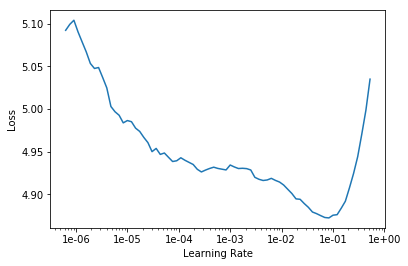

In [23]:
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.226807,4.083314,0.291856


In [25]:
learn.save('fit_head')

In [26]:
learn.load('fit_head');

In [27]:
learn.unfreeze()
learn.fit_one_cycle(20, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.971501,3.921529,0.307012
2,3.945125,3.857285,0.315353
3,3.868089,3.814046,0.322049
4,3.848203,3.784429,0.326018
5,3.802185,3.759927,0.328479
6,3.772834,3.740162,0.330361
7,3.716213,3.722749,0.332302
8,3.690576,3.710284,0.333781
9,3.680033,3.695916,0.335227
10,3.643237,3.684859,0.336495


In [28]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [29]:
learn.load('fine_tuned');

In [30]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [31]:
print("\n".join(learn.predict(TEXT, N_WORDS) for _ in range(N_SENTENCES)))

i liked this movie because xxmaj burt xxmaj reynolds 's style was a really good movie job . i give it a 7 out of 10 xxbos xxmaj the trailers appear directly on the xxup dvd and xxup vhs looking to be false as they
i liked this movie because it 's very understated in its drugs presentation / dialogue . xxmaj do yourself a favor and do n't listen to anyone who or i purchase this movie . i do n't think i could ever sit through a version


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [32]:
learn.save_encoder('fine_tuned_enc')

# Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [33]:
path = untar_data(URLs.IMDB)

In [37]:
path

PosixPath('/root/.fastai/data/imdb')

In [36]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #remove docs with labels not in above list (i.e. 'unsup')
             .filter_missing_y()
             #label them all with their folders
             .databunch(bs=bs))
data_clas.save('tmp_clas')

TypeError: 'bool' object is not callable

In [ ]:
len(data_clas.train_ds)

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
data_clas.show_batch()

We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

In [ ]:
learn.save('third')

In [35]:
learn.load('third');

FileNotFoundError: [Errno 2] No such file or directory: '/root/.fastai/data/imdb/models/third.pth'

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

In [ ]:
learn.predict("I really loved that movie, it was awesome!")